In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import array_to_latex as ltx

In [3]:
%matplotlib inline

## Некоторые функции для работы

In [4]:
def mean_wt(u,sigma):
    '''
    the function calculates the average of values with "weights"
    :param u: data array
    :param sigma: data array with errors
    :return: average value with "weights"
    '''
    w=sigma_u**(-2)
    S=np.sum(w)
    mean_u=np.sum(w*u)/S
    return mean_u

In [5]:
def D_wt(x,y,sigma):
    '''function calculates covariance with "weights"'''
    D_xy_weight = mean_wt(x*y,sigma)-mean_wt(x,sigma)*mean_wt(y,sigma)
    return D_xy_weight
def D(x,y):
    '''func calculates the covariance'''
    D_xy = np.mean(x*y)-np.mean(x)*np.mean(y)
    return D_xy

### Метод наименьших квадратов (МНК)
Найдём коэффициенты наилучшей прямой по методу наименьших квадратов (МНК). Для простоты погрешности всех точек будем считать приблизительно одинаковыми. Тогда можно воспользоваться формулами
\begin{equation}
k = \frac{\langle xy \rangle - \langle x \rangle \langle y \rangle}{\langle x^2 \rangle - \langle x \rangle ^2}
= \frac{D_{xy}}{D_{xx}}
, \quad b = \langle y \rangle - k \langle x \rangle
\end{equation}
Вычислим $\textit{случайные}$ погрешности определения коэффициентов прямой c двумя уравнениями связи: 
\begin{equation}
\sigma_k = \sqrt{\frac{1}{n-2} \left(\frac{\langle y^2 \rangle - \langle y \rangle^2}{\langle x^2 \rangle - \langle x \rangle^2}-k^2\right)} = \sqrt{\frac{1}{n-2} \left(\frac{D_{yy}}{D_{xx}}-k^2\right)}
,\qquad \sigma_b = \sigma_k \sqrt{\langle x^2 \rangle }
\end{equation}
где введена $\textit{ковариация}$ $D_{xy}=\langle \Delta x \cdot \Delta y \rangle = \langle xy \rangle - \langle x \rangle \langle y \rangle$
С одним уравнением связи:
\begin{equation}
k = \frac{\langle xy \rangle }{\langle x^2 \rangle }, \quad
\sigma_k = \sqrt{\frac{1}{n-1} \left(\frac{\langle y^2 \rangle }{\langle x^2 \rangle } - k^2 \right)}
\end{equation}

### Метод $\chi$и-квадрат (МНК с "весами")
МНК с весами получается из классического МНК заменой среднего на $\textit{взвешанное среднее}$:
\begin{equation}
\langle x \rangle_{\chi^2} = \frac{1}{W} \sum_{i=1}^{N} \omega_{i} x_{i}
\end{equation}
где $W = \sum_{i=1}^{N} \omega_{i} $ и $ \omega_{i} = 1/\sigma^2_{i}$

In [6]:
def approximation_MNK(x,y,sigma=1,p=2,output=True, weights=False, chi=False):
    '''
    the function calculates the main parameters
    for plotting a graph using the least squares method (MNK): classic or with weights.
    :param x: x-axis data array
    :param y: y-axis data array
    :param sigma: y-axis error
    :param p: number of connection equations
    :param output: display of chart parameters on the screen
    :param chi: chi square calculation
    :param weights: using the chi square method
    :return: array with chart parameters and their errors
    '''
    if len(x)==len(y):
        n=len(x)
        if not weights:
            if p == 2:
                '''with two coupling equations'''
                k = D(x,y)/D(x,x)
                b = np.mean(y) - k*np.mean(x)
                sigma_k = ((n-p)**-0.5)*((D(y,y)/D(x,x)-k**2)**0.5)
                sigma_b = sigma_k * np.sqrt(np.mean(x**2))
                if output:
                    print(f'k = %.3f, b = %.3f,\nsigma_k = %.3f, sigma_b = %.3f,\nek = %.2f, eb = %.2f' % (k,b,sigma_k,sigma_b,sigma_k/k*100,sigma_b/b*100))   
                return (k,b,sigma_k,sigma_b)
            elif p == 1:
                '''with one coupling equations'''
                k = np.mean(x*y)/np.mean(x**2)
                b = 0
                sigma_k = ((n-p)**-0.5)*((np.mean(y**2)/np.mean(x**2)-k**2)**0.5)
                if output:
                    print(f'k = %.3f, sigma_k = %.3f, ek = %.2f' % (k,sigma_k,sigma_k/k*100))   
                return (k,sigma_k)
        else:
            if p == 2:
                '''with two coupling equations'''
                k = D_wt(x,y,sigma)/D_wt(x,x,sigma)
                b = mean_wt(y,sigma) - k*mean_wt(x,sigma)
                sigma_k = ((n-p)**-0.5)*((D_wt(y,y,sigma)/D_wt(x,x,sigma)-k**2)**0.5)
                sigma_b = sigma_k * sqrt(mean_wt(x**2,sigma))
                if output:
                    print(f'k = %.3f, b = %.3f,\nsigma_k = %.3f, sigma_b = %.3f,\nek = %.2f, eb = %.2f' % (k,b,sigma_k,sigma_b,sigma_k/k * 100,sigma_b/b * 100))   
                return (k,b,sigma_k,sigma_b)
            elif p == 1:
                '''with one coupling equations'''
                k = mean_wt(x*y,sigma)/np.mean(x**2,sigma)
                b = 0
                sigma_k = ((n-p)**-0.5)*((mean_wt(y**2,sigma)/mean_wt(x**2,sigma)-k**2)**0.5)
                if output:
                    print(f'k = %.3f, sigma_k = %.3f, ek = %.2f' % (k,sigma_k,sigma_k/k*100)) 
                return (k,sigma_k)
        if chi:
            chi2,specific_chi2 = chi_2(sigma,n,p)
            print(f'X^2 = %.3f, X^2/(n-p) = %.3f' % (chi2,specific_chi2))
    else:
        print('''you're a asshole, Ha - Ha !!!''')

### Сумма $\chi$и-квадрат
Для проверки качества аппроксимации, вычислим сумму $\chi^2$:
\begin{equation}
\chi^2 = \sum_{i=1}^{N} \left(\frac{\Delta y_{i}}{\sigma_{y_{i}}}\right)^2
\end{equation}
В случае нормального распределение ошибок можно ожидать, что большая часть отклонений данных от модели будет порядка одной среднеквадратичной ошибки: $\Delta y_{i} = \sigma_{y_{i}}$. Следовательно, сумма $\chi$и-квадрат окажется по порядку величины равна числу входящих в неё слагаемых: $\chi^2 \backsim 
 n$.

Таким образом нормированная (на число степеней свободы) величина $\chi^2/(n-p)$ должна в среднем быть равна единице.
 
Значения существенно большие (2 и выше) свидетельствуют либо о $\textit{плохом соответствии теории и результатов измерений}$, либо о $\textit{заниженных погрешностях}$. Значения меньше 0,5 как правило свидетельствуют о $\textit{завышенных погрешностях}$.

In [7]:
def chi_2(sigma,n,p):
    '''
    function calculates chi square
    :param sigma: array of error values
    :param p: number of connection equations
    :param n:total number of points to build
    :return: an array with the value of the chi-squared
     sum and the chi-squared sum from the normalized to the number of degrees of freedom
    '''
    chi2 = np.sum(((y - (k * x + b)) / sigma)**2)
    freedom_degree = n - p
    return (chi2, chi2/degree_freedom)

In [8]:
x = np.linspace(0.01, 0.5, 50)
y = np.linspace(7, -10, 50)
k,b,sigma_k,sigma_b = approximation_MNK(x,y)

k = -34.694, b = 7.347,
sigma_k = 0.000, sigma_b = 0.000,
ek = -0.00, eb = 0.00


## Начало основной программы

In [37]:
data_array = pd.read_csv("data_sort_by_combing.csv",  sep=";", decimal=",").iloc[:,:]
data_array

,25000,20000,100,Unnamed: 3
0,75300,8329,200,NaN
1,188300,16404,300,NaN
2,298800,33729,400,NaN
3,458500,48692,500,NaN
4,567700,65487,600,NaN
...,...,...,...,...
94,126943200,16314167,9600,NaN
95,129901000,16538612,9700,NaN
96,132800200,16763442,9800,NaN
97,132725500,16911433,9900,NaN


In [38]:
time=data_array.iloc[:,0].to_numpy()
swap=data_array.iloc[:,1].to_numpy()
N=data_array.iloc[:,2].to_numpy()


In [44]:
def line(x1,y1,st='None',name='None',OY='None',OX='None',size=(15, 10),sizex=(0.993, 0),sizey=(0, 0.993), limx=[50,170],limy=[2,8]):
    plt.figure(figsize=size)
    plt.rcParams['font.size'] = '15'

    k1,b1,sigma_k1,sigma_b1=approximation_MNK(x1,y1)
    y1_approx = k1*x1+b1


    plt.scatter(x1,y1, marker='H',color='#0000FF', s=8, label=st)
    plt.plot(x1,y1_approx, '-', color='#FF0000', linewidth=1)


    #plt.plot(x, y, 'ro',ms =5,label="Экспериментальные точки c ")
    #plt.errorbar(x, y, xerr=sigma_x, yerr=sigma_y, fmt="+k", label='Экспериментальные точки')

    #plt.scatter(x2,y2, marker='D', s=70, label="Данные при понижении температуры")

    #plt.xlim(limx)
    #plt.ylim(limy)

    ##— Decorate the spins
    #arrow_length = 20 # In points
#
    ## X-axis arrow
    #plt.annotate(OX, xy=sizex, xycoords=('axes fraction', 'data'),
    #xytext=(arrow_length, 0), textcoords='offset points',
    #ha='left', va='center',
    #arrowprops=dict(arrowstyle='<|-', fc='black'))
#
    ## Y-axis arrow
    #plt.annotate(OY, xy=sizey, xycoords=('data', 'axes fraction'),
    #xytext=(0, arrow_length), textcoords='offset points',
    #ha='center', va='bottom',
    #arrowprops=dict(arrowstyle='<|-', fc='black'))

    plt.minorticks_on()
    plt.grid(which='major', lw=2)
    plt.grid(which='minor', lw=1)
    plt.legend(loc = 'upper left',prop={"size":14})
    
    plt.savefig(f'pictures\{name}.png')
    plt.show()

k = 1.934, b = 0.847,
sigma_k = 0.009, sigma_b = 0.071,
ek = 0.44, eb = 8.38


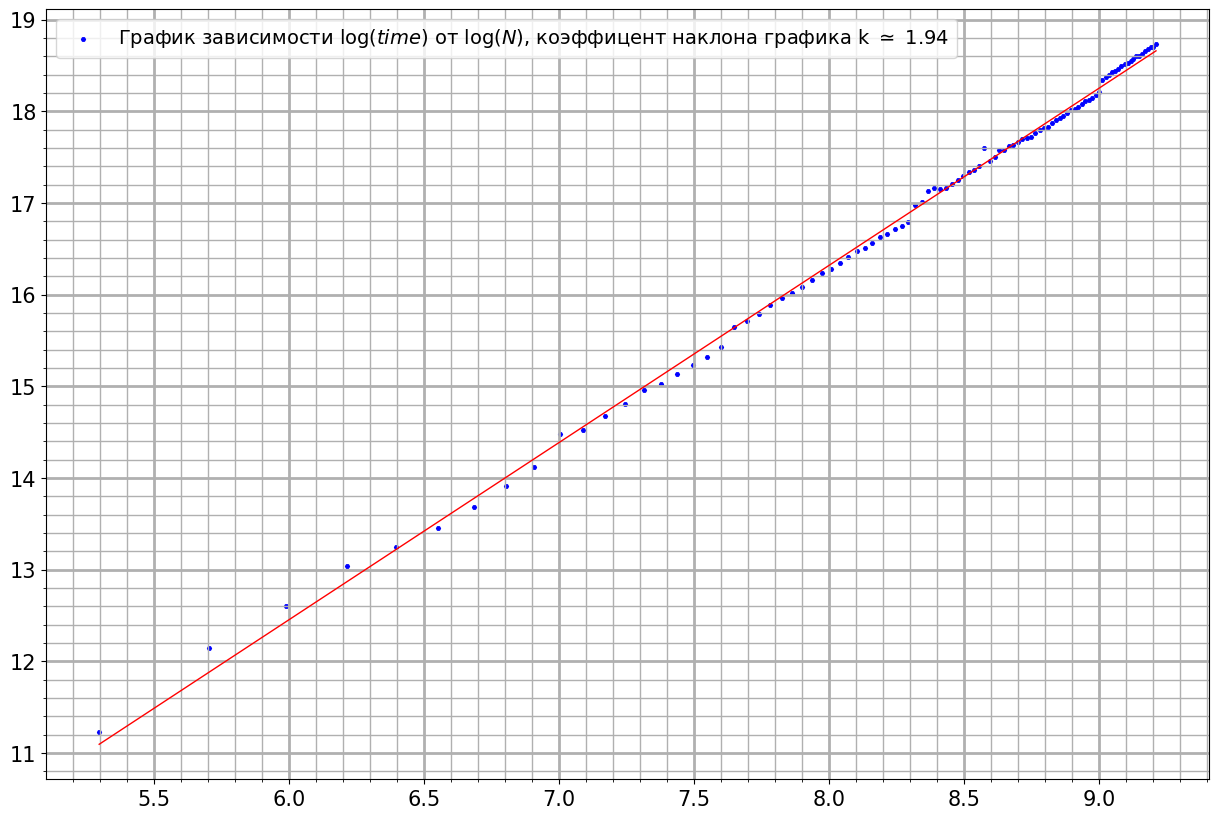

In [45]:
line(np.log(N),np.log(time),st='График зависимости $\log(time)$ от $\log(N)$, коэффицент наклона графика k $\simeq$ 1.94',name='graph_sort_by_combing_TIME(N)',OY='$\log(time)$',OX='$\log(N)$',size=(15, 10),sizex=(0.993, 0),sizey=(0, 0.993), limx=[0,312],limy=[2700,6600])

k = 1.984, b = -1.567,
sigma_k = 0.007, sigma_b = 0.054,
ek = 0.33, eb = -3.47


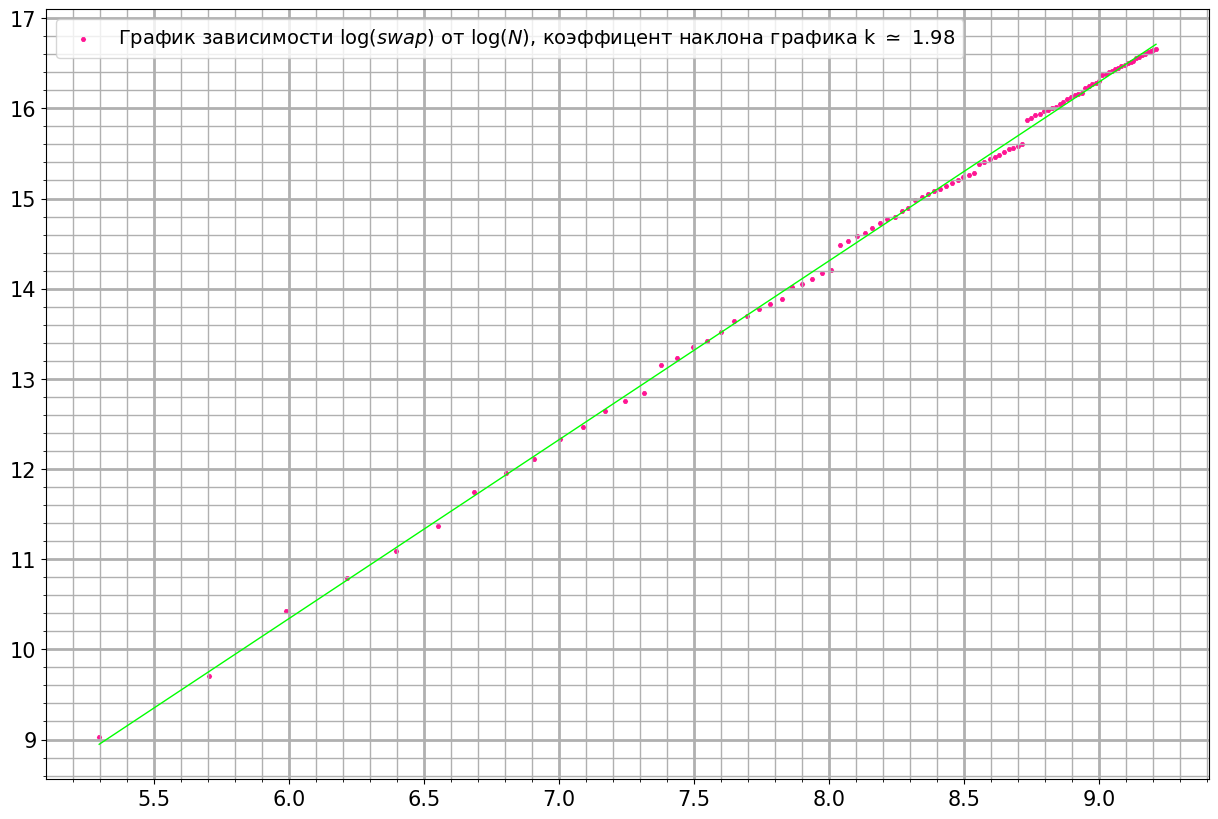

In [41]:
line(np.log(N),np.log(swap),st='График зависимости $\log(swap)$ от $\log(N)$, коэффицент наклона графика k $\simeq$ 1.98',name='graph_sort_by_combing_swap(N)',OY='$\log(time)$',OX='$\log(N)$',size=(15, 10),sizex=(0.993, 0),sizey=(0, 0.993), limx=[0,312],limy=[2700,6600])